In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
import pylidc as pl
import numpy as np
import copy
import pandas as pd

from pydicom import dcmread
from glob import glob
from PIL import Image, ImageDraw
from tqdm import tqdm
from scipy.sparse import csc_matrix

import matplotlib.pyplot as plt
import matplotlib.patches as patches


## Extract All Images From Scan

In [14]:
all_scans = pl.query(pl.Scan).all()
scan = all_scans[1]
images = scan.load_all_dicom_images()

Loading dicom files ... This may take a moment.


In [11]:
pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(['LIDC-IDRI-0077', 'LIDC-IDRI-0078', 'LIDC-IDRI-0079'])).all()


[Scan(id=1,patient_id=LIDC-IDRI-0078),
 Scan(id=3,patient_id=LIDC-IDRI-0079),
 Scan(id=87,patient_id=LIDC-IDRI-0077)]

In [15]:
images[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.117963215769670774290217686980
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.117963215769670774290217686980
(0008, 0020) Study Date                 

## Extract All Annotations From Scan

In [18]:
all_annotations = scan.annotations
all_annotations

[Annotation(id=14,scan_id=2),
 Annotation(id=15,scan_id=2),
 Annotation(id=16,scan_id=2),
 Annotation(id=17,scan_id=2),
 Annotation(id=18,scan_id=2),
 Annotation(id=19,scan_id=2),
 Annotation(id=20,scan_id=2),
 Annotation(id=21,scan_id=2),
 Annotation(id=22,scan_id=2)]

## Extract Contour Coordinates For 1 Annotation, Image pair

In [19]:
contour = all_annotations[0].contours[0]
coords = contour.to_matrix(include_k=False)
coords = np.flip(coords, axis=1)


In [20]:
image = images[contour.image_k_position]


In [21]:
window_center = int(image.WindowCenter)
window_width = int(image.WindowWidth)

hu_values = image.pixel_array

## Convert Image from HU to Grayscale cmap

In [23]:
min_hu, max_hu = (window_center - window_width/2, window_center + window_width/2)
img = copy.copy(hu_values)
img[img > max_hu] = max_hu
img[img < min_hu] = min_hu
img = (img - min_hu)/(max_hu - min_hu)
# img = (img*255).astype(np.int32)
# img = np.repeat(img[:, :, np.newaxis], 3, axis=2)


## Visualise image and annotation coordinates

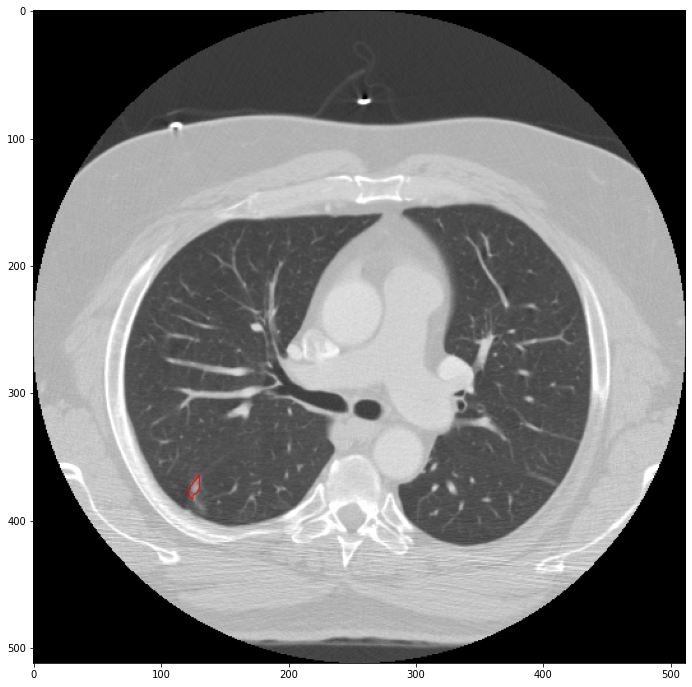

In [24]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img, cmap='gray')

segmap = patches.Polygon(coords, closed=True, linewidth=1,
                         edgecolor='r', facecolor='none')
ax.add_patch(segmap)


## Create Mask from Contour Coordinates

In [25]:
dummy_img = Image.new('L', (img.shape[1], img.shape[0]), 0)
ImageDraw.Draw(dummy_img).polygon(list(map(tuple, coords)), outline=1, fill=1)
mask = np.array(dummy_img)
np.unique(mask)


array([0, 1], dtype=uint8)

## Visualise Mask

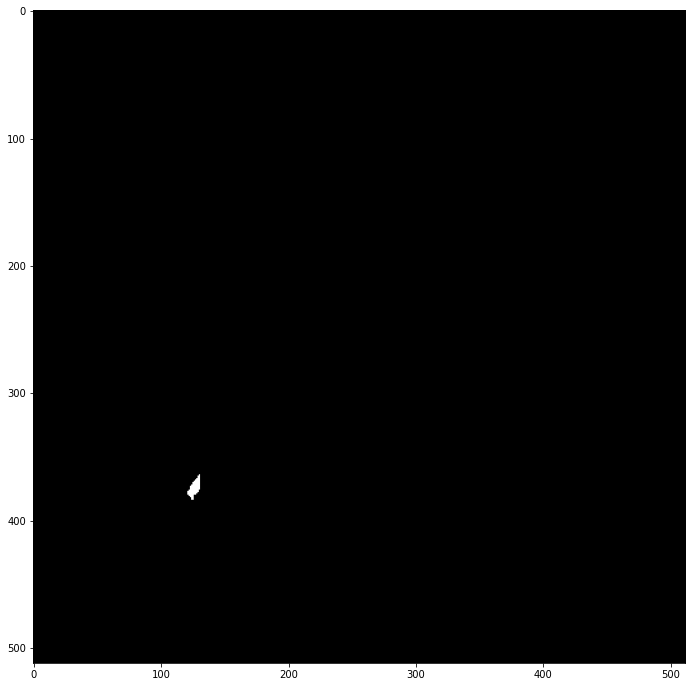

In [196]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(mask, cmap='gray')
